<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://raw.githubusercontent.com/Unidata/MetPy/master/src/metpy/plots/_static/unidata_150x150.png" alt="Unidata Logo" style="height: 98px;">
</div>

<h1>Extract HRRR data using Unidata's Siphon package and Xarray</h1>
<h3>Unidata Python Workshop</h3>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
# Resolve the latest HRRR dataset
from siphon.catalog import get_latest_access_url

hrrr_catalog = "http://thredds.ucar.edu/thredds/catalog/grib/NCEP/HRRR/CONUS_2p5km/catalog.xml"
latest_hrrr_ncss = get_latest_access_url(hrrr_catalog, "NetcdfSubset")

# Set up access via NCSS
from siphon.ncss import NCSS
ncss = NCSS(latest_hrrr_ncss)

# Create a query to ask for all times in netcdf4 format for
# the Temperature_surface variable, with a bounding box
query = ncss.query()

In [3]:
query.all_times().accept('netcdf4').variables('Temperature_height_above_ground')
query.lonlat_box(north=45, south=41, east=-67, west=-77)

# Get the raw bytes and write to a file.
data = ncss.get_data_raw(query)
with open('test.nc', 'wb') as outf:
    outf.write(data)

## Try reading extracted data with Xarray

In [4]:
import xarray as xr

In [5]:
nc = xr.open_dataset('test.nc')

In [6]:
nc

<xarray.Dataset>
Dimensions:                          (height_above_ground1: 1, time: 19, x: 365, y: 240)
Coordinates:
  * time                             (time) datetime64[ns] 2020-01-09T14:00:00 ... 2020-01-10T08:00:00
  * height_above_ground1             (height_above_ground1) float32 2.0
  * y                                (y) float32 1907.6554 ... 2514.6443
  * x                                (x) float32 1508.5632 ... 2433.0151
Data variables:
    Temperature_height_above_ground  (time, height_above_ground1, y, x) float32 ...
    LambertConformal_Projection      int32 ...
Attributes:
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by_originating...
    Conventions:                                                             ...
    history:                                                                 ...
    featureType:                                                             ...
    History:                                                                 ...
    geospatial_lat_min:                                                      ...
    geospatial_lat_max:                                                      ...
    geospatial_lon_min:                                                      ...
    geospatial_lon_max:                                                      ...

In [7]:
var='Temperature_height_above_ground'
ncvar = nc[var]
ncvar

<xarray.DataArray 'Temperature_height_above_ground' (time: 19, height_above_ground1: 1, y: 240, x: 365)>
[1664400 values with dtype=float32]
Coordinates:
  * time                  (time) datetime64[ns] 2020-01-09T14:00:00 ... 2020-01-10T08:00:00
  * height_above_ground1  (height_above_ground1) float32 2.0
  * y                     (y) float32 1907.6554 1910.1951 ... 2514.6443
  * x                     (x) float32 1508.5632 1511.1029 ... 2433.0151
Attributes:
    long_name:                      Temperature @ Specified height level abov...
    units:                          K
    abbreviation:                   TMP
    grid_mapping:                   LambertConformal_Projection
    Grib_Variable_Id:               VAR_0-0-0_L103
    Grib2_Parameter:                [0 0 0]
    Grib2_Parameter_Discipline:     Meteorological products
    Grib2_Parameter_Category:       Temperature
    Grib2_Parameter_Name:           Temperature
    Grib2_Level_Type:               103
    Grib2_Level_Desc:               Specified height level above ground
    Grib2_Generating_Process_Type:  Forecast

In [8]:
grid = nc[ncvar.grid_mapping]
grid

<xarray.DataArray 'LambertConformal_Projection' ()>
array(0, dtype=int32)
Attributes:
    grid_mapping_name:              lambert_conformal_conic
    latitude_of_projection_origin:  25.0
    longitude_of_central_meridian:  265.0
    standard_parallel:              25.0
    earth_radius:                   6371229.0
    _CoordinateTransformType:       Projection
    _CoordinateAxisTypes:           GeoX GeoY

In [9]:
lon0 = grid.longitude_of_central_meridian
lat0 = grid.latitude_of_projection_origin
lat1 = grid.standard_parallel
earth_radius = grid.earth_radius

## Try plotting the LambertConformal data with Cartopy

In [10]:
import cartopy
import cartopy.crs as ccrs

In [11]:
#cartopy wants meters, not km
x = ncvar.x.data*1000.
y = ncvar.y.data*1000.

In [12]:
#globe = ccrs.Globe(ellipse='WGS84') #default
globe = ccrs.Globe(ellipse='sphere', semimajor_axis=grid.earth_radius)

crs = ccrs.LambertConformal(central_longitude=lon0, central_latitude=lat0, 
                            standard_parallels=(lat0,lat1), globe=globe)

In [13]:
print(ncvar.x.data.shape)
print(ncvar.y.data.shape)
print(ncvar.data.shape)

(365,)
(240,)
(19, 1, 240, 365)


In [14]:
# find the correct time dimension name
for d in ncvar.dims:
    if "time" in d: 
        timevar = d
nc[timevar].data[6]

numpy.datetime64('2020-01-09T20:00:00.000000000')

/home/travis/miniconda/envs/unidata/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/10m/physical/ne_10m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


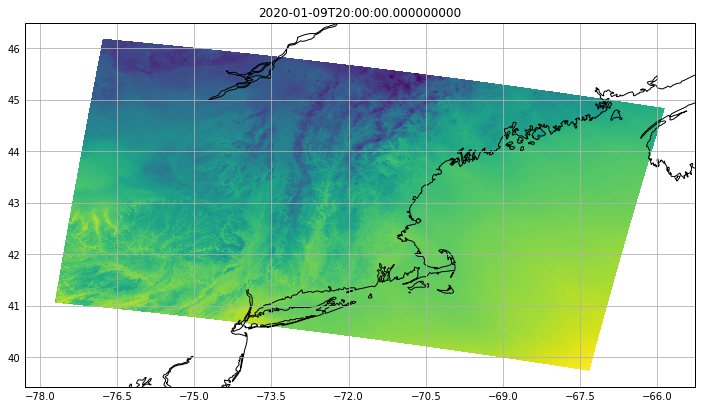

In [15]:
istep = 6
fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.PlateCarree())
mesh = ax.pcolormesh(x,y,ncvar[istep,::].data.squeeze(), transform=crs,zorder=0)
ax.coastlines(resolution='10m',color='black',zorder=1)
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
plt.title(nc[timevar].data[istep]);